In [16]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
from collections import Counter
import tensorflow as tf
import seaborn as sns
from PIL import Image
import keras
import pickle
from tqdm import tqdm
import datetime,time
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D,Bidirectional,Add
from nltk.translate.bleu_score import sentence_bleu

In [7]:
def your_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [28]:
# Load the pre-trained encoder model
loaded_encoder = tf.keras.models.load_model('./FinalModels/encoder_model')

# Load the pre-trained decoder model
loaded_decoder = tf.keras.models.load_model('./FinalModels/decoder_model')

# Manually compile the models
optimizer = tf.keras.optimizers.Adam()  # Use the optimizer you used during training
print('complie')
# Compile the models
loaded_encoder.compile(optimizer=optimizer)
loaded_decoder.compile(optimizer=optimizer, loss=your_loss_function)
print(loaded_decoder.summary())

# Now, you can use the loaded_encoder and loaded_decoder for evaluation or further training


complie
Model: "decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention_model_1 (Attentio  multiple                 394753    
 n_model)                                                        
                                                                 
 embedding_1 (Embedding)     multiple                  1280256   
                                                                 
 gru_1 (GRU)                 multiple                  1575936   
                                                                 
 dense_9 (Dense)             multiple                  262656    
                                                                 
 dense_10 (Dense)            multiple                  2565513   
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                 

In [17]:
# Load the tokenizer
tokenizer_path = './FinalModels/tokenizer.pkl'
with open(tokenizer_path, 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

In [29]:
def evaluate_V1(image, loaded_encoder, loaded_decoder, max_length, tokenizer, attention_features_shape):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Manually initialize the hidden state for the Decoder
    hidden = tf.zeros((1, loaded_decoder.layers[2].units))  # Adjust units based on your GRU layer

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = loaded_encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = loaded_decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [31]:
def load_image(image_path):    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)    
    return img, image_path

In [33]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model =keras.Model(new_input, hidden_layer)

In [37]:
def evaluate(image, loaded_encoder, loaded_decoder, max_length, tokenizer, attention_features_shape):
    attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = loaded_decoder.init_state(batch_size=1)
    hidden = loaded_decoder.layers[0].cell.get_initial_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)  # process the input image to the desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = loaded_encoder(img_tensor_val)  # extract the features by passing the input to the loaded encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = loaded_decoder(dec_input, features, hidden)  # get the output from the loaded decoder

#         attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        attention_plot[i] = tf.reshape(attention_weights, (attention_weights.shape[1], attention_weights.shape[2])).numpy()



        predicted_id = tf.argmax(predictions[0]).numpy()  # extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        # map the id to the word from the tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [46]:
image_path='./CaptionDataSet_1000/images/2098418613_85a0c9afea.jpg'
max_length = 35
attention_features_shape=64

In [47]:
result, attention_plot, predictions = evaluate_V1(image_path, loaded_encoder, loaded_decoder, max_length, loaded_tokenizer, attention_features_shape)

In [48]:
print(result)

['a', 'brown', 'dog', 'stands', 'in', 'a', 'green', 'van', 'in', 'the', 'yard', 'of', 'a', 'green', 'van', 'in', 'the', 'yard', 'of', 'a', 'green', 'van', 'in', 'the', 'yard', 'of', 'a', 'green', 'van', 'in', 'the', 'yard', 'of', 'a', 'green']


In [49]:
pred_caption=' '.join(result).rsplit(' ', 1)[0]

In [50]:
print(pred_caption)

a brown dog stands in a green van in the yard of a green van in the yard of a green van in the yard of a green van in the yard of a


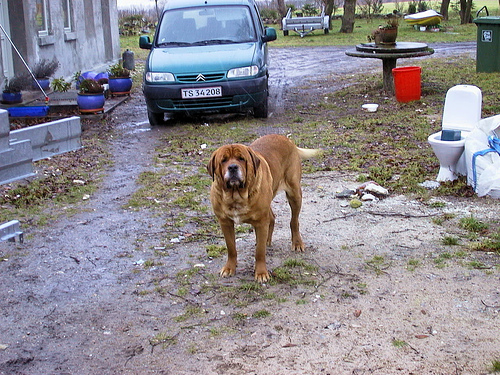

In [51]:
Image.open(image_path)